Hidden Markov Model for Carbon Filter Health

Business Problem:
My company (Calgon Carbon) supplies granular activated carbon (GAC) to Municipal Drinking Water plants to use as a filter media in their water treatment system. Over time, the filter media (GAC) gradually loses adsorption capacity and eventually "breaks through" (contaminant levels at the outlet exceed a limit).

The true "health state" of the filter is hidden:
    S0: Healthy
    S1: Mid-life
    S2: Near breakthrough
    S3: Failed / breakthrough

What we CAN observe (at regular time intervals, weekly) is the effluent contaminant concentration. These measurements are noisy.

To make the model more realistic, we bucket each measurement into 6 categories defined relative to a regulatory or contractual limit L
for that contaminant.

 "L" be the maximum allowed effluent concentration (mg/L) and I define each category:
    0: Excellent  (effluent < 0.05 * L)
    1: Very good  (0.05 * L <= effluent < 0.15 * L)
    2: Good       (0.15 * L <= effluent < 0.40 * L)
    3: Caution    (0.40 * L <= effluent < 0.70 * L)
    4: High       (0.70 * L <= effluent < 1.00 * L)
    5: Critical   (effluent >= 1.00 * L)

Goal:
1. Define an HMM that encodes how filter health evolves over time.
2. Simulate a synthetic life of a carbon filter.
3. Use Viterbi to infer the most likely health sequence.
4. Generate Matplotlib visuals for presentation.

In [18]:
#Imports 
import numpy as np
import matplotlib.pyplot as plt

In [19]:
#Define model components
#For reproducibility (so you get the same random example each run)
np.random.seed(42)

#Hidden states (health states of the filter)
state_names = ["Healthy", "Mid-life", "Near breakthrough", "Failed"]
num_states = len(state_names)

#Observation symbols (binned effluent concentration relative to limit L)
obs_names = [
    "Excellent (<5% of limit)", #0
    "Very good (5–15%)", #1
    "Good (15–40%)", #2
    "Caution (40–70%)", #3
    "High (70–100%)", #4
    "Critical (>=100%)" #5
]
num_observations = len(obs_names)

#Initial state distribution pi:
#We assume a fresh filter at the start, so almost certainly "Healthy".
pi = np.array([0.99, 0.01, 0.0, 0.0])  #(must sum to 1)

#Transition probability matrix A (num_states x num_states)
#A[i, j] = P(next_state = j | current_state = i)
A = np.array([
    #To:  Healthy   Mid-life  Near BT   Failed
    [0.85,   0.15,    0.00,     0.00], #from Healthy
    [0.00,   0.80,    0.20,     0.00], #from Mid-life
    [0.00,   0.00,    0.75,     0.25], #from Near breakthrough
    [0.00,   0.00,    0.00,     1.00], #from Failed (absorbing)
])

#Emission probability matrix B (num_states x num_observations)
# B[i, k] = P(observation_symbol = k | state = i)
#
#We choose these numbers to reflect the idea that:
#Healthy: almost always far below the limit (Excellent / Very good / Good)
#Mid-life: more Good / Caution, with some High
#Near breakthrough: Caution / High / Critical are common
#Failed: mostly High / Critical
#
#NOTE: rows must each sum to 1 (within rounding).
B = np.array([
    # Obs:  Excell.  VeryGood  Good    Caution High   Critical
    [0.55,   0.30,    0.10,    0.04,   0.01,   0.00],  #Healthy
    [0.10,   0.25,    0.35,    0.20,   0.08,   0.02],  #Mid-life
    [0.02,   0.08,    0.25,    0.35,   0.20,   0.10],  #Near breakthrough
    [0.00,   0.02,    0.08,    0.15,   0.35,   0.40],  #Failed
])

In [20]:
#Helper Function (simulate a sequence from HMM)
def sample_discrete(prob_vector):
    #Sample an index from a discrete probability distribution.
    #prob_vector: 1D numpy array of probabilities that sum to 1.
    #returns: integer index i with P(i) = prob_vector[i]
    
    return np.random.choice(len(prob_vector), p=prob_vector)


def simulate_hmm(T, pi, A, B):

    #Simulate a hidden state sequence and an observation sequence of length T from the HMM defined by pi, A, B.
    #T: number of time steps (e.g., weeks)
    #pi: initial state distribution (num_states)
    #A: transition matrix (num_states x num_states)
    #B: emission matrix (num_states x num_observations)

    #returns:
        #states: list of length T of hidden state indices
        #observations: list of length T of observation indices

    #Interpretation in our business context:
    #'states[t]' tells us the "true" health state of the filter at week t.
    #(In practice this is hidden from the operator.)
    #'observations[t]' tells us which effluent category we observed at week t,
    #(example) "Excellent (<5% of limit)" or "Caution (40–70%)".
      
    num_states = A.shape[0]
    num_obs = B.shape[1]

    states = []
    observations = []

    #Sample the initial state at time t = 0
    s0 = sample_discrete(pi)
    states.append(s0)

    #Sample the observation at time t = 0 given state s0
    o0 = sample_discrete(B[s0])
    observations.append(o0)

    #Now sample remaining T-1 steps
    for t in range(1, T):
        # Transition from previous state
        prev_state = states[-1]
        new_state = sample_discrete(A[prev_state])
        states.append(new_state)

        # Emit an observation from the new state
        new_observation = sample_discrete(B[new_state])
        observations.append(new_observation)

    return states, observations

In [21]:
#Viterbi algorithm: infer most likely state sequence
def viterbi(obs_seq, pi, A, B):
    #Viterbi algorithm for discrete HMM.

    #obs_seq: list/array of observation indices (length T)
    #pi: initial state distribution (num_states)
    #A: transition matrix (num_states x num_states)
    #B: emission matrix (num_states x num_observations)

    #returns:
        #best_path: most likely sequence of states (length T)
        #delta: DP table of max log-probabilities
        #psi: DP table of backpointers (which state we came from)

    #Business interpretation:
    #Given only the sequence of observed effluent categories over time, the Viterbi algorithm finds the single most likely "health history" of the filter that could have generated those observations.

    obs_seq = np.array(obs_seq)
    T = len(obs_seq)
    N = A.shape[0]  #number of states

    #Work in log space to avoid underflow:
    #log(x*y) = log(x) + log(y), log(sum) we avoid by using max in Viterbi.
    logA = np.log(A + 1e-12)  # small constant to avoid log(0)
    logB = np.log(B + 1e-12)
    logpi = np.log(pi + 1e-12)

    #delta[t, i] = max log-probability of any path that ends in state i at time t
    delta = np.zeros((T, N))
    #psi[t, i]   = argmax previous state that gives best path to state i at t
    psi = np.zeros((T, N), dtype=int)

    #Initialization (t = 0)
    for i in range(N):
        delta[0, i] = logpi[i] + logB[i, obs_seq[0]]
        psi[0, i] = 0  # no previous state at t=0

    #Recursion (t = 1..T-1)
    for t in range(1, T):
        for j in range(N):
            #For each possible current state j at time t,
            #try all previous states i and pick the max.
            log_probs = delta[t - 1] + logA[:, j]
            best_prev_state = np.argmax(log_probs)
            delta[t, j] = log_probs[best_prev_state] + logB[j, obs_seq[t]]
            psi[t, j] = best_prev_state

    #Termination: find best final state at time T-1
    best_last_state = np.argmax(delta[T - 1])
    best_path_log_prob = delta[T - 1, best_last_state]

    #Backtrack to recover the best path
    best_path = [best_last_state]
    for t in range(T - 1, 0, -1):
        best_prev_state = psi[t, best_path[-1]]
        best_path.append(best_prev_state)
    best_path.reverse()  # reverse to get path from t=0 to t=T-1

    return best_path, delta, psi

In [22]:
#Print bast text summary

#Number of time steps to simulate (40 weeks of operation)
T = 40

#Step 1: simulate a "true" life of the filter
true_states, observations = simulate_hmm(T, pi, A, B)

#Step 2: infer the most likely health state sequence from observations only
viterbi_states, delta, psi = viterbi(observations, pi, A, B)

print("*** HMM for Carbon Filter Health (Expanded Observation Model) ***\n")
print(f"Number of time steps (in weeks): {T}\n")

print("Legend:")
print("  States (hidden):")
for i, name in enumerate(state_names):
    print(f"    {i} -> {name}")
print("\n  Observations (effluent buckets, relative to limit):")
for k, name in enumerate(obs_names):
    print(f"    {k} -> {name}")
print("\n")

print("First 15 time steps (True state vs. Viterbi estimate vs. Observation):")
print("t | True State        | Viterbi State     | Observation bucket")
print("------------------------------------------------------------------------")
for t in range(min(15, T)):
    ts = state_names[true_states[t]]
    vs = state_names[viterbi_states[t]]
    obs = obs_names[observations[t]]
    print(f"{t:2d}| {ts:18s} | {vs:17s} | {obs}")

print("\n")

#Count how often each state appears in the Viterbi path
viterbi_counts = np.bincount(viterbi_states, minlength=num_states)
print("Estimated time spent in each health state (Viterbi path):")
for i, name in enumerate(state_names):
    print(f"  {name:18s}: {viterbi_counts[i]} time steps (~{100 * viterbi_counts[i] / T:.1f}%)")
print("\n")

print("Last 10 time steps (focus on when we approach failure):")
print("t | True State        | Viterbi State     | Observation bucket")
print("--------------------------------------------------------------------------")
start = max(0, T - 10)
for t in range(start, T):
    ts = state_names[true_states[t]]
    vs = state_names[viterbi_states[t]]
    obs = obs_names[observations[t]]
    print(f"{t:2d}| {ts:18s} | {vs:17s} | {obs}")

*** HMM for Carbon Filter Health (Expanded Observation Model) ***

Number of time steps (in weeks): 40

Legend:
  States (hidden):
    0 -> Healthy
    1 -> Mid-life
    2 -> Near breakthrough
    3 -> Failed

  Observations (effluent buckets, relative to limit):
    0 -> Excellent (<5% of limit)
    1 -> Very good (5–15%)
    2 -> Good (15–40%)
    3 -> Caution (40–70%)
    4 -> High (70–100%)
    5 -> Critical (>=100%)


First 15 time steps (True state vs. Viterbi estimate vs. Observation):
t | True State        | Viterbi State     | Observation bucket
------------------------------------------------------------------------
 0| Healthy            | Healthy           | Caution (40–70%)
 1| Healthy            | Healthy           | Very good (5–15%)
 2| Healthy            | Healthy           | Excellent (<5% of limit)
 3| Healthy            | Healthy           | Good (15–40%)
 4| Healthy            | Healthy           | Very good (5–15%)
 5| Healthy            | Healthy           | Caut

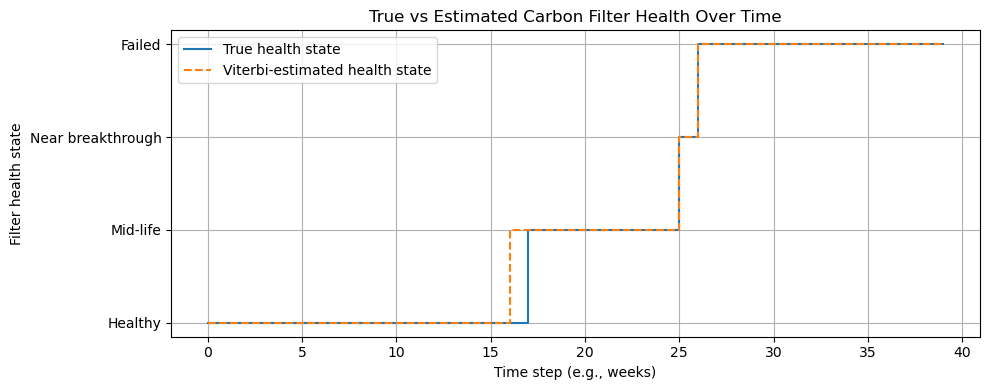

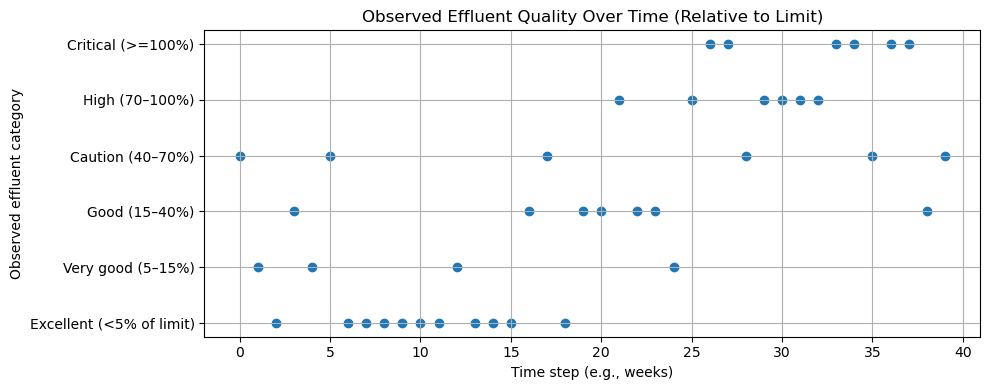

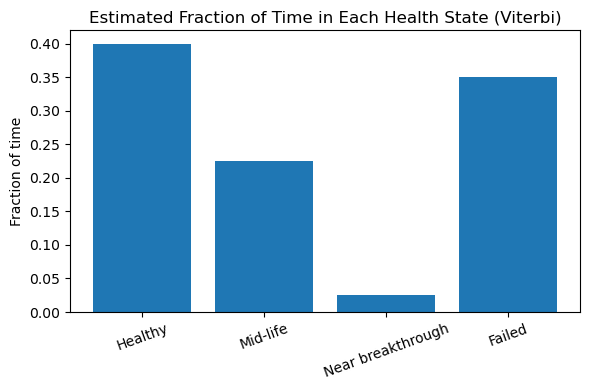

In [23]:
#Matplotlib visuals
#Plot 1: True vs Viterbi filter health over time
time = np.arange(T)

plt.figure(figsize=(10, 4))
plt.step(time, true_states, where="post", label="True health state")
plt.step(time, viterbi_states, where="post", linestyle="--", label="Viterbi-estimated health state")
plt.yticks(range(len(state_names)), state_names)
plt.xlabel("Time step (e.g., weeks)")
plt.ylabel("Filter health state")
plt.title("True vs Estimated Carbon Filter Health Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 2: Observation categories over time
plt.figure(figsize=(10, 4))
plt.scatter(time, observations)
plt.yticks(range(len(obs_names)), obs_names)
plt.xlabel("Time step (e.g., weeks)")
plt.ylabel("Observed effluent category")
plt.title("Observed Effluent Quality Over Time (Relative to Limit)")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 3: Time spent in each health state (Viterbi)
plt.figure(figsize=(6, 4))
plt.bar(range(len(state_names)), viterbi_counts / T)
plt.xticks(range(len(state_names)), state_names, rotation=20)
plt.ylabel("Fraction of time")
plt.title("Estimated Fraction of Time in Each Health State (Viterbi)")
plt.tight_layout()
plt.show()